In [1]:
import numpy as np
import pandas as pd
import requests
import random
from io import BytesIO
import pickle
from collections import OrderedDict
import os
from os import path
import time
import argparse
import wget
import ast
import json
from PIL import Image, ImageDraw, ImageOps
import ndjson
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# import pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
categories = ['apple', 'clock', 'door', 'diamond', 'fork', 'eye', 'star', 'axe', 'sword', 'fish']
data_filepath = '../datasets'
num_categories = len(categories)
num_examples = 3000
label_dict = {}
width = 256
height = 256

In [3]:
for i in range(0,num_categories):
    label_dict[i] = categories[i]

Save label dictionary

In [4]:
with open('../service/label_dict.json', 'w') as f:
    json.dump(categories, f)

### Download datasets

Google quickdraw dataset (<a href='https://github.com/googlecreativelab/quickdraw-dataset#the-raw-moderated-dataset'>More</a>)

In [5]:
# URL to dataset in GCP Storage
dataset_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

In [6]:
for category in categories:
    if not os.path.exists(data_filepath + '/' + str(category) + '.npy'):
        print("Start downloading data process for [{}].".format(category))
        url = dataset_url + str(category) + '.npy'
        wget.download(
                    url=url,
                    out=data_filepath
                )
        print("Dataset for {} was successfully downloaded.".format(category))
    else:
        print("Dataset for {} is already downloaded.".format(category))

Dataset for apple is already downloaded.
Dataset for clock is already downloaded.
Dataset for door is already downloaded.
Dataset for diamond is already downloaded.
Dataset for fork is already downloaded.
Dataset for eye is already downloaded.
Dataset for star is already downloaded.
Dataset for axe is already downloaded.
Dataset for sword is already downloaded.
Dataset for fish is already downloaded.


### Prepare datasets

In [7]:
classes_dict = {}
for category in categories:
    classes_dict[category] = np.load(data_filepath + '/' + str(category) + '.npy')

In [8]:
# Generate labels and add labels to loaded data
for i, (key, value) in enumerate(classes_dict.items()):
    value = value.astype('float32')/255.
    if i == 0:
        classes_dict[key] = np.c_[value, np.zeros(len(value))]
    else:
        classes_dict[key] = np.c_[value,i*np.ones(len(value))]

lst = []
for key, value in classes_dict.items():
    lst.append(value[:num_examples])
tmp = np.concatenate(lst)

# Split the data into features and class labels (X & y respectively)
y = tmp[:,-1].astype('float32')
X = tmp[:,:784]

# Split each dataset into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

### Generate new data

In [1]:
def convert_to_PIL(img):
    img_r = img.reshape(28,28)

    pil_img = Image.new('RGB', (28, 28), 'white')
    pixels = pil_img.load()

    for i in range(0, 28):
        for j in range(0, 28):
            if img_r[i, j] > 0:
                pixels[j, i] = (255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255))

    return pil_img

In [2]:
def convert_to_np(pil_img):
    pil_img = pil_img.convert('RGB')

    img = np.zeros((28, 28))
    pixels = pil_img.load()

    for i in range(0, 28):
        for j in range(0, 28):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img

In [3]:
def rotate_image(src_im, angle = 45, size = (28,28)):
    dst_im = Image.new("RGBA", size, "white")
    src_im = src_im.convert('RGBA')

    rot = src_im.rotate(angle)
    dst_im.paste(rot, (0, 0), rot)

    return dst_im

In [4]:
def flip_image(src_im):
    dst_im = src_im.transpose(Image.FLIP_LEFT_RIGHT)
    return dst_im

In [5]:
def join_transformed_images(X_train, y_train):
    print("Adding flipped and rotated images to the training set.")

    X_train_new = X_train.copy()
    y_train_new = y_train.copy().reshape(y_train.shape[0], 1)

    for i in range(0, X_train.shape[0]):
        # get image to rotate and flip
        img = X_train[i]
        pil_img = convert_to_PIL(img)

        # get random angle
        angle = random.randint(5, 10)

        # rotate and flip
        rotated = convert_to_np(rotate_image(pil_img, angle))
        flipped = convert_to_np(flip_image(pil_img))

        # add to the original dataset
        X_train_new = np.append(X_train_new, rotated.reshape(1, 784), axis = 0)
        X_train_new = np.append(X_train_new, flipped.reshape(1, 784), axis = 0)
        y_train_new = np.append(y_train_new, y_train[i].reshape(1,1), axis = 0)
        y_train_new = np.append(y_train_new, y_train[i].reshape(1,1), axis = 0)

        # print out progress
        if i % 100 == 0:
            print("Processed {i} files out of {total}.".format(i= i, total = X_train.shape[0]))

    return X_train_new, y_train_new

In [9]:
X_train, y_train = join_transformed_images(X_train, y_train)

Adding flipped and rotated images to the training set. 

Processed 0 files out of 21000.
Processed 100 files out of 21000.
Processed 200 files out of 21000.
Processed 300 files out of 21000.
Processed 400 files out of 21000.
Processed 500 files out of 21000.
Processed 600 files out of 21000.
Processed 700 files out of 21000.
Processed 800 files out of 21000.
Processed 900 files out of 21000.
Processed 1000 files out of 21000.
Processed 1100 files out of 21000.
Processed 1200 files out of 21000.
Processed 1300 files out of 21000.
Processed 1400 files out of 21000.
Processed 1500 files out of 21000.
Processed 1600 files out of 21000.
Processed 1700 files out of 21000.
Processed 1800 files out of 21000.
Processed 1900 files out of 21000.
Processed 2000 files out of 21000.
Processed 2100 files out of 21000.
Processed 2200 files out of 21000.
Processed 2300 files out of 21000.
Processed 2400 files out of 21000.
Processed 2500 files out of 21000.
Processed 2600 files out of 21000.
Processed 

### Create stage

In [16]:
def save_np_data(data, file_name):
    with open('{}/{}'.format(data_filepath, file_name), 'wb') as f:
        np.save(f, data)
    
def load_np_data(file_name):
    with open('{}/{}'.format(data_filepath, file_name), 'rb') as f:
        return np.load(f)

In [17]:
save_np_data(X_train, 'X_train.npy')
save_np_data(y_train, 'y_train.npy')

### Load from stage

In [21]:
X_train = load_np_data('X_train.npy')
y_train = load_np_data('y_train.npy')

In [27]:
def view_images_grid(X, y, label_dict):
    fig, axs = plt.subplots(5, 10, figsize=(20,10))
    
    for label_num in range(0,50):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  #reshape images
        i = label_num // 10
        j = label_num % 10
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(label_dict[int(y[r_label])])

    plt.show()

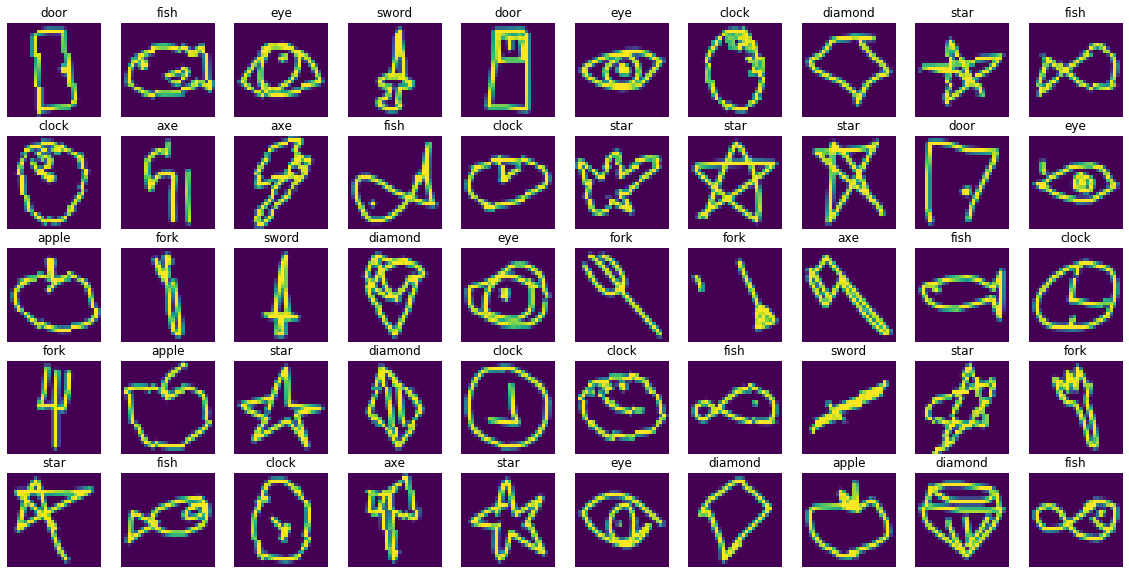

In [28]:
view_images_grid(X_train, y_train, label_dict)

In [29]:
X_tensor_train = torch.from_numpy(X_train).float()
y_tensor_train = torch.from_numpy(y_train).long()
X_tensor_test = torch.from_numpy(X_test).float()
y_tensor_test = torch.from_numpy(y_test).long()

### Describe model

In [30]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 100, 64]
output_size = 10
dropout = 0.0

In [31]:
def build_model(input_size = 784, output_size = 10, hidden_sizes = [128, 100, 64]):
    return nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                            ('bn2', nn.BatchNorm1d(num_features = hidden_sizes[1])),
                            ('relu2', nn.ReLU()),
                            ('dropout', nn.Dropout(dropout)),
                            ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                            ('bn3', nn.BatchNorm1d(num_features = hidden_sizes[2])),
                            ('relu3', nn.ReLU()),
                            ('logits', nn.Linear(hidden_sizes[2], output_size))]))

### Research

In [32]:
train = X_tensor_train
train_labels = y_tensor_train
test = X_tensor_test
test_labels = y_tensor_test

In [33]:
def shuffle(X_train, y_train):
    X_train_shuffled = X_train.numpy()
    y_train_shuffled = y_train.numpy().reshape((X_train.shape[0], 1))

    permutation = list(np.random.permutation(X_train.shape[0]))
    X_train_shuffled = X_train_shuffled[permutation, :]
    y_train_shuffled = y_train_shuffled[permutation, :].reshape((X_train.shape[0], 1))

    X_train_shuffled = torch.from_numpy(X_train_shuffled).float()
    y_train_shuffled = torch.from_numpy(y_train_shuffled).long()

    return X_train_shuffled, y_train_shuffled

In [34]:
def fit_model(model, X_train, y_train, epochs = 100, n_chunks = 1000, learning_rate = 0.003, weight_decay = 0):
    print("Fitting model with epochs = {epochs}, learning rate = {lr}"\
    .format(epochs = epochs, lr = learning_rate))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    print_every = 100
    steps = 0

    for e in range(epochs):
        running_loss = 0

        X_train, y_train = shuffle(X_train, y_train)

        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)

        for i in range(n_chunks):
            steps += 1

            optimizer.zero_grad()

            # Forward and backward passes
            output = model.forward(images[i])
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                print("Epoch: {}/{} ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every))

                running_loss = 0

In [35]:
def get_preds(model, input):
    with torch.no_grad():
        logits = model.forward(input)

    ps = F.softmax(logits, dim=1)
    return ps

In [36]:
def get_labels(pred):
    pred_np = pred.numpy()
    pred_values = np.amax(pred_np, axis=1, keepdims=True)
    pred_labels = np.array([np.where(pred_np[i, :] == pred_values[i, :])[0] for i in range(pred_np.shape[0])])
    pred_labels = pred_labels.reshape(len(pred_np), 1)

    return pred_labels

In [37]:
def evaluate_model(model, train, y_train, test, y_test):
    train_pred = get_preds(model, train)
    train_pred_labels = get_labels(train_pred)

    test_pred = get_preds(model, test)
    test_pred_labels = get_labels(test_pred)

    accuracy_train = accuracy_score(y_train, train_pred_labels)
    accuracy_test = accuracy_score(y_test, test_pred_labels)

    print("Accuracy score for train set is {}".format(accuracy_train))
    print("Accuracy score for test set is {}".format(accuracy_test))
    return accuracy_train, accuracy_test

Plot learning curve depending on the number of epochs.

In [38]:
learning_rate = 0.003
weight_decay = 0.0
n_chunks = 1000

In [39]:
epochs_range = np.arange(10, 150, 10)
train_acc = []
test_acc = []

for epochs in epochs_range:
    model = build_model(input_size, output_size, hidden_sizes)
    fit_model(model, train, train_labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay)
    accuracy_train, accuracy_test = evaluate_model(model, train, train_labels, test, test_labels)

    train_acc.append(accuracy_train)
    test_acc.append(accuracy_test)

Fitting model with epochs = 10, learning rate = 0.003
Epoch: 1/10  Loss: 0.8489
Epoch: 1/10  Loss: 0.5637
Epoch: 1/10  Loss: 0.5003
Epoch: 1/10  Loss: 0.4918
Epoch: 1/10  Loss: 0.4540
Epoch: 1/10  Loss: 0.4508
Epoch: 1/10  Loss: 0.3909
Epoch: 1/10  Loss: 0.4057
Epoch: 1/10  Loss: 0.4010
Epoch: 1/10  Loss: 0.3770
Epoch: 2/10  Loss: 0.3258
Epoch: 2/10  Loss: 0.3337
Epoch: 2/10  Loss: 0.3431
Epoch: 2/10  Loss: 0.3405
Epoch: 2/10  Loss: 0.3447
Epoch: 2/10  Loss: 0.3255
Epoch: 2/10  Loss: 0.3329
Epoch: 2/10  Loss: 0.3082
Epoch: 2/10  Loss: 0.3345
Epoch: 2/10  Loss: 0.3005
Epoch: 3/10  Loss: 0.2643
Epoch: 3/10  Loss: 0.2599
Epoch: 3/10  Loss: 0.2581
Epoch: 3/10  Loss: 0.2779
Epoch: 3/10  Loss: 0.2697
Epoch: 3/10  Loss: 0.2840
Epoch: 3/10  Loss: 0.2835
Epoch: 3/10  Loss: 0.2839
Epoch: 3/10  Loss: 0.2748
Epoch: 3/10  Loss: 0.2742
Epoch: 4/10  Loss: 0.2383
Epoch: 4/10  Loss: 0.2226
Epoch: 4/10  Loss: 0.2387
Epoch: 4/10  Loss: 0.2328
Epoch: 4/10  Loss: 0.2380
Epoch: 4/10  Loss: 0.2285
Epoch: 4/1

Text(0, 0.5, 'Accuracy')

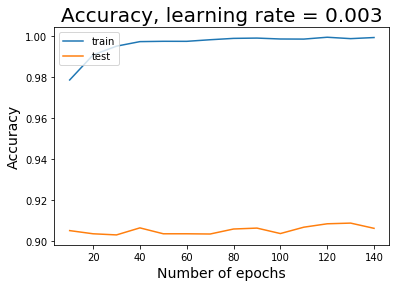

In [50]:
x = epochs_range
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning rate = ' + str(learning_rate), fontsize=20)
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

### Train turget model

In [41]:
epochs = 100
n_chunks = 1000
learning_rate = 0.003
weight_decay = 0

In [42]:
model = build_model()

In [43]:
fit_model(model, train, train_labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay)

Fitting model with epochs = 100, learning rate = 0.003
Epoch: 1/100  Loss: 0.8222
Epoch: 1/100  Loss: 0.5615
Epoch: 1/100  Loss: 0.4997
Epoch: 1/100  Loss: 0.5076
Epoch: 1/100  Loss: 0.4487
Epoch: 1/100  Loss: 0.3965
Epoch: 1/100  Loss: 0.4304
Epoch: 1/100  Loss: 0.4229
Epoch: 1/100  Loss: 0.3964
Epoch: 1/100  Loss: 0.3991
Epoch: 2/100  Loss: 0.3279
Epoch: 2/100  Loss: 0.3553
Epoch: 2/100  Loss: 0.3427
Epoch: 2/100  Loss: 0.3320
Epoch: 2/100  Loss: 0.3066
Epoch: 2/100  Loss: 0.3243
Epoch: 2/100  Loss: 0.3298
Epoch: 2/100  Loss: 0.3090
Epoch: 2/100  Loss: 0.3207
Epoch: 2/100  Loss: 0.3421
Epoch: 3/100  Loss: 0.2691
Epoch: 3/100  Loss: 0.2621
Epoch: 3/100  Loss: 0.2764
Epoch: 3/100  Loss: 0.2604
Epoch: 3/100  Loss: 0.2631
Epoch: 3/100  Loss: 0.2828
Epoch: 3/100  Loss: 0.2872
Epoch: 3/100  Loss: 0.2594
Epoch: 3/100  Loss: 0.2788
Epoch: 3/100  Loss: 0.2630
Epoch: 4/100  Loss: 0.2060
Epoch: 4/100  Loss: 0.2346
Epoch: 4/100  Loss: 0.2473
Epoch: 4/100  Loss: 0.2521
Epoch: 4/100  Loss: 0.2458


Epoch: 89/100  Loss: 0.0060
Epoch: 89/100  Loss: 0.0074
Epoch: 89/100  Loss: 0.0143
Epoch: 89/100  Loss: 0.0120
Epoch: 89/100  Loss: 0.0125
Epoch: 89/100  Loss: 0.0142
Epoch: 89/100  Loss: 0.0141
Epoch: 89/100  Loss: 0.0097
Epoch: 89/100  Loss: 0.0113
Epoch: 89/100  Loss: 0.0174
Epoch: 90/100  Loss: 0.0150
Epoch: 90/100  Loss: 0.0180
Epoch: 90/100  Loss: 0.0134
Epoch: 90/100  Loss: 0.0123
Epoch: 90/100  Loss: 0.0128
Epoch: 90/100  Loss: 0.0097
Epoch: 90/100  Loss: 0.0090
Epoch: 90/100  Loss: 0.0087
Epoch: 90/100  Loss: 0.0117
Epoch: 90/100  Loss: 0.0085
Epoch: 91/100  Loss: 0.0093
Epoch: 91/100  Loss: 0.0075
Epoch: 91/100  Loss: 0.0121
Epoch: 91/100  Loss: 0.0120
Epoch: 91/100  Loss: 0.0158
Epoch: 91/100  Loss: 0.0121
Epoch: 91/100  Loss: 0.0173
Epoch: 91/100  Loss: 0.0170
Epoch: 91/100  Loss: 0.0144
Epoch: 91/100  Loss: 0.0108
Epoch: 92/100  Loss: 0.0092
Epoch: 92/100  Loss: 0.0110
Epoch: 92/100  Loss: 0.0113
Epoch: 92/100  Loss: 0.0116
Epoch: 92/100  Loss: 0.0123
Epoch: 92/100  Loss:

In [44]:
evaluate_model(model, train, train_labels, test, test_labels)

Accuracy score for train set is 0.9988730158730159
Accuracy score for test set is 0.9035555555555556


(0.9988730158730159, 0.9035555555555556)

In [45]:
filepath = '../service/models/model.nnet'

In [46]:
metainfo = {'input_size': input_size,
            'output_size': output_size,
            'hidden_layers': hidden_sizes,
            'dropout': dropout,
            'state_dict': model.state_dict()}

torch.save(metainfo, filepath)
print("Model saved to {}\n".format(filepath))

Model saved to ../service/models/model.nnet

